In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

# Household heterogeneous block
def household_guess(a_grid, r, z_grid, gamma, T, tauc):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1 + r) * a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1 + r) / (1 + tauc) * (wel * 0.1) ** (-gamma) # check
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p, a_grid, z_grid, e_grid, r, T, beta, gamma, tauc):
    
    c_prime = (beta * (1 + tauc) * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t
    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid
    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) / (1 + tauc) * c ** (-gamma) # check

    # Check for violation of the asset constraint and fix it
    indexes_asset = np.nonzero(a < a_grid[0]) # first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:  
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset]) / (1 + tauc)
        V_prime[indexes_asset] = (1 + r) / (1 + tauc) * (c[indexes_asset]) ** (-gamma) # check
    uce = e_grid[:,np.newaxis] * c ** (-gamma)
    return V_prime, a, c, uce

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

def income(e_grid, w, N, taun):
    z_grid = (1 - taun) * w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho = rho_e, sigma = sd_e, N = nE)
    a_grid = grids.agrid(amin = amin, amax = amax, n = nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    transfer_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  Transfer / np.sum(pi_e * transfer_rule) * transfer_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

print(hh_inp)
print(f'Inputs: {hh_inp.inputs}')
print(f'Outputs: {hh_inp.outputs}')

<HetBlock 'household'>
Inputs: ['a_grid', 'z_grid', 'e_grid', 'r', 'T', 'beta', 'gamma', 'tauc', 'Pi']
Macro outputs: ['A', 'C', 'UCE']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'uce']
<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'beta', 'gamma', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer', 'w', 'N', 'taun']
Outputs: ['A', 'C', 'UCE']


In [2]:
# Simple blocks
@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y / Z
    Div = Y - w * N - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return Div, N

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    i = rstar
    return r, i

# Fiscal block with EXOGENOUS transfer TO BE REPLACED
#@simple
#def fiscal(r, Transfer, B, C, N, tauc, taun, w):
#    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * N - B
#    Deficit = Transfer - tauc * C - taun * w * N # primary deficit
#    Trans = Transfer
#    return govt_res, Deficit, Trans

# Fiscal block with ENDOGENOUS transfer TO REPLACE PREVIOUS ONE
@simple
def fiscal(r, B, N, taun, w):
    #Transfer = B - (1 + r) * B(-1) # new rule with variable debt
    Transfer = taun * w * N + B - (1 + r) * B(-1) # new rule with variable debt and taxes
    return Transfer

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w, N, UCE, kappaw, nu, muw, tauc, taun):
    phi = ((1 - taun) * w * N ** (-nu) * UCE) / ((1 + tauc) * muw) # our formula
    wnkpc = kappaw * (phi * N ** (1 + nu) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw))
    return wnkpc, phi

blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]
hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")
print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'taun', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B', 'kappaw', 'nu', 'muw']


In [3]:
calibration = {'gamma': 1.0, 'nu': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 6.0,
               'kappaw': 0.006, 'muw': 1.05, 'N': 1.0, 'tauc': 0.0, 'taun': 0.0}

# Old with EXOGENOUS transfer
#unknowns_ss = {'beta': 0.986, 'Transfer': -0.03} 
#targets_ss = {'asset_mkt': 0, 'govt_res': 0}

# New with ENDOGENOUS transfer
unknowns_ss = {'beta': 0.986} 
targets_ss = {'asset_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

In [4]:
@simple
def wage(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@simple
def union(piw, w, N, UCE, kappaw, phi, nu, muw, beta, tauc, taun):
    wnkpc = (kappaw * (phi * N ** (1+nu) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw)) 
             + beta * (1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log))
    return wnkpc

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name = "One-Asset HANK")

ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))
    
T = 300
# Old with ENDOGENOUS transfer
#exogenous = ['rstar','Transfer', 'Z', 'tauc']
#unknowns = ['pi', 'w', 'Y', 'B']
#targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# New with EXOGENOUS transfer
exogenous = ['rstar', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc']


# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
#print(G)

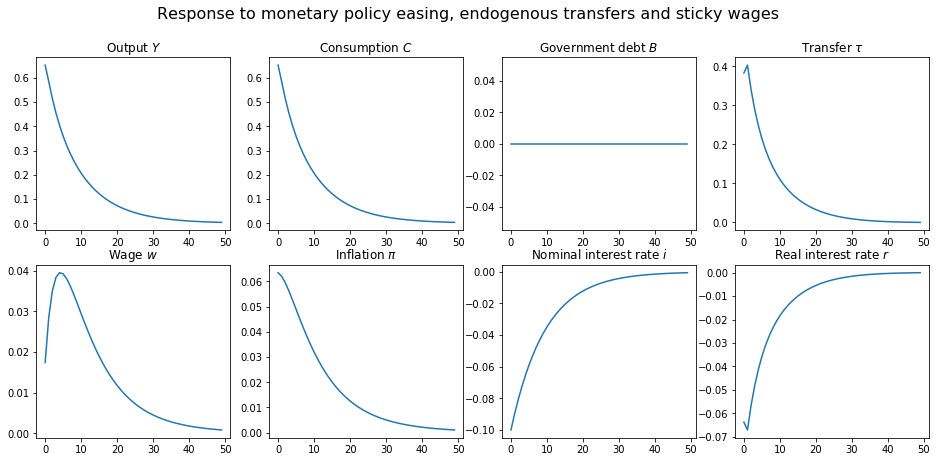

-------------------------------------------------------------------------
PARAMETERS
Discount factor                0.989   Intertemporal elasticity     1.000
Labor supply elasticity        0.500   Labor supply disutility      0.784
Goods substitutability         6.000   Price markup                 1.200
Labor substitutability        21.000   Wage markup                  1.050
Price Phillips slope           0.100   Taylor rule inflation        1.500
Wage Phillips slope            0.006   Taylor rule output           0.000
Consumption tax rate           0.000   Labor tax rate               0.000

VARIABLES
Output                         1.000   Government debt              6.000
Consumption                    1.000   Transfers                   -0.030
Hours                          1.000   Dividends                    0.167
Wage                           0.833   Marginal cost                0.833
Inflation                      0.000   Consumption tax revenue      0.000
Nominal interest

In [5]:
# Impulse response functions
rhos = 0.9
drstar = -0.1 * rhos ** (np.arange(T)[:, np.newaxis])

dY = G['Y']['rstar'] @ drstar
dC = G['C']['rstar'] @ drstar
dN = G['N']['rstar'] @ drstar
dB = G['A']['rstar'] @ drstar
dw = G['w']['rstar'] @ drstar
dp = G['pi']['rstar'] @ drstar
dr = G['r']['rstar'] @ drstar
dd = G['Div']['rstar'] @ drstar
dT = G['Transfer']['rstar'] @ drstar
di = G['i']['rstar'] @ drstar

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)
fig.suptitle('Response to monetary policy easing, endogenous transfers and sticky wages', size=16)

ax[0, 0].set_title(r'Output $Y$')
ax[0, 0].plot(dY[:50, :])

ax[0, 1].set_title(r'Consumption $C$')
ax[0, 1].plot(dC[:50, :])

ax[0, 2].set_title(r'Government debt $B$')
ax[0, 2].plot(np.around(dB[:50, :], decimals = 4) * ss0['A'])

ax[0, 3].set_title(r'Transfer $\tau$')
ax[0, 3].plot(dT[:50, :])

ax[1, 0].set_title(r'Wage $w$')
ax[1, 0].plot(dw[:50, :])

ax[1, 1].set_title(r'Inflation $\pi$')
ax[1, 1].plot(dp[:50, :])

ax[1, 2].set_title(r'Nominal interest rate $i$')
ax[1, 2].plot(di[:50, :])

ax[1, 3].set_title(r'Real interest rate $r$')
ax[1, 3].plot(dr[:50, :])
plt.show()
        
# Show steady state
ss_param = [['Discount factor', ss0['beta'], 'Intertemporal elasticity', ss0['gamma']],
        ['Labor supply elasticity', 1 / ss0['nu'], 'Labor supply disutility', ss0['phi']],  
        ['Goods substitutability', ss0['mu'] / (ss0['mu'] - 1) , 'Price markup', ss0['mu']],
        ['Labor substitutability', ss0['muw'] / (ss0['muw'] - 1), 'Wage markup', ss0['muw']],
        ['Price Phillips slope', ss0['kappa'], 'Taylor rule inflation ', ss0['phi_pi']],
        ['Wage Phillips slope', ss0['kappaw'], 'Taylor rule output ', 0],
        ['Consumption tax rate', ss0['tauc'], 'Labor tax rate', ss0['taun']]]

ss_var = [['Output', ss0['Y'], 'Government debt', ss0['A']],
        ['Consumption', ss0['C'], 'Transfers', ss0['Transfer']],
        ['Hours', ss0['N'], 'Dividends', ss0['Div']], 
        ['Wage', ss0['w'], 'Marginal cost', ss0['w'] / ss0['Z']],
        ['Inflation', ss0['pi'], 'Consumption tax revenue', ss0['tauc'] * ss0['C']],
        ['Nominal interest rate', ss0['r']*(1+ss0['pi']), 'Labor tax revenue', ss0['taun']*ss0['N']*ss0['w']],
        ['Real interest rate', ss0['r'], 'Debt servicing  cost', ss0['r'] * ss0['A']]]
ss_mkt = [['Bond market', ss0['asset_mkt'], 'Goods market (resid)', ss0['goods_mkt']]]

dash = '-' * 73
print(dash)
print('PARAMETERS')
for i in range(len(ss_param)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_param[i][0],ss_param[i][1],ss_param[i][2],ss_param[i][3]))
print('\nVARIABLES')
for i in range(len(ss_var)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_var[i][0],ss_var[i][1],ss_var[i][2],ss_var[i][3]))
print('\nMARKET CLEARING')
for i in range(len(ss_mkt)):
      print('{:<24s}{:>12.0e}   {:24s}{:>10.0e}'.format(ss_mkt[i][0],ss_mkt[i][1],ss_mkt[i][2],ss_mkt[i][3]))
print(dash) 
